In [1]:
import torch
import pickle as pkl
import sys
import numpy as np

sys.path += ["../mlpf"]
from pyg.mlpf import MLPF

import onnxruntime
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

2024-02-13 13:52:24.331200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 13:52:24.331268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 13:52:24.332809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 13:52:24.341623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 13:52:25.728013: W tensorflow/compiler/tf2

In [2]:
loaddir = "../experiments/pyg-cms_20240210_013116_879112/"
with open(f"{loaddir}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)
model_kwargs["attention_type"] = "flash"

In [3]:
model = MLPF(**model_kwargs)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

3954966


In [4]:
checkpoint = torch.load("../experiments/pyg-cms_20240210_013116_879112/best_weights.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

MLPF(
  (nn0): Sequential(
    (0): Linear(in_features=55, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_id): ModuleList(
    (0-2): 3 x SelfAttentionLayer(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (seq): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ELU(alpha=1.0)
      )
      (dropout): Dropout(p=0.3, inplace=False)
      (add0): FloatFunctional(
        (activation_post_process): Identity()
      )
      (add1): FloatFunctional(

In [59]:
weight_observer = torch.ao.quantization.HistogramObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_affine, 
                                                              quant_min=-127, quant_max=127)
activation_observer = torch.ao.quantization.HistogramObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_affine, 
                                                              quant_min=-127, quant_max=127)
dynamic_qconfig = torch.ao.quantization.QConfig(weight=weight_observer, activation=activation_observer)
model.qconfig = dynamic_qconfig
torch.backends.quantized.engine = 'x86'
model_fp32_prepared = torch.ao.quantization.prepare(model)

In [60]:
ds_builder = tfds.builder("cms_pf_ttbar", data_dir = '/scratch/persistent/joosep/tensorflow_datasets/')
dss = ds_builder.as_data_source("train")

In [90]:
arrs = []
for i in range(1000):
    arrs.append(dss[i]["X"])
arrs = np.concatenate(arrs)

In [61]:
for i in range(10):
    data = torch.unsqueeze(torch.tensor(dss[i]["X"]), axis=0)
    print(i, data.shape)
    batch  = torch.ones((data.shape[0], data.shape[1]), dtype=torch.bool)
    model_fp32_prepared(data, batch)

0 torch.Size([1, 3578, 55])
1 torch.Size([1, 3700, 55])
2 torch.Size([1, 3750, 55])
3 torch.Size([1, 3979, 55])
4 torch.Size([1, 3359, 55])
5 torch.Size([1, 3900, 55])
6 torch.Size([1, 4172, 55])
7 torch.Size([1, 4575, 55])
8 torch.Size([1, 3386, 55])
9 torch.Size([1, 3591, 55])


In [62]:
model_fp32_prepared.nn0[0]

Linear(
  in_features=55, out_features=256, bias=True
  (activation_post_process): HistogramObserver(min_val=-908.0415649414062, max_val=565.940185546875)
)

In [63]:
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:1263: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [66]:
batch_quantized = torch.quantize_per_tensor(batch.to(dtype=torch.float), 1, 0, torch.qint8)
data_quantized = model_int8.quant(data)

In [67]:
plt.scatter(
    model(data, batch)[1][:, :, 0].detach().numpy(),
    model_int8(data, batch_quantized)[1][:, :, 0].detach().numpy()
)

RuntimeError: Expected input data type QUInt8 but got QInt8

In [11]:
# model(data, batch)
# export_options = torch.onnx.ExportOptions(dynamic_shapes=True)
# onnx_program = torch.onnx.dynamo_export(model, data, batch, export_options=export_options)
# onnx_program.save("transformer.onnx")

# sess_options = onnxruntime.SessionOptions()
# sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL

# onnx_sess = onnxruntime.InferenceSession("transformer.onnx", sess_options=sess_options, providers=["CPUExecutionProvider"])
# out = onnx_sess.run(None, {"l_x_features_": data2.numpy(), "mask": batch2.numpy()})

In [168]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(55, 256),
            torch.nn.ELU(),
            torch.nn.Linear(256, 512),
            torch.nn.ELU(),
            torch.nn.Linear(512, 2048)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ELU(),
            torch.nn.Linear(512, 256),
            torch.nn.ELU(),
            torch.nn.Linear(256, 55),
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [169]:
model = AE()
model.train()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

In [170]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    losses = []
    for data in arrs[:10000]:
        data = torch.unsqueeze(torch.tensor(data), 0)
        # Output of Autoencoder
        reconstructed = model(data)
        loss = torch.nn.functional.mse_loss(reconstructed, data) + 1e-7*torch.sum((reconstructed - 128)**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())
    print(epoch, np.mean(losses))

0 88.26418518727422
1 17.540176194311677
2 12.13200537403673
3 6.9554963936984535
4 4.653642993283272
5 3.6164099189937113
6 2.9987788682475687
7 2.681734647089243
8 2.347468012714386
9 2.4161999052226544
10 2.0002506992578506
11 1.8191444613546133
12 2.299649054895341
13 2.181335497085005
14 2.1209556744746862
15 1.950788396485895
16 1.929884956792742
17 2.0637831831380726
18 1.5014379033975302
19 1.9883390856795014


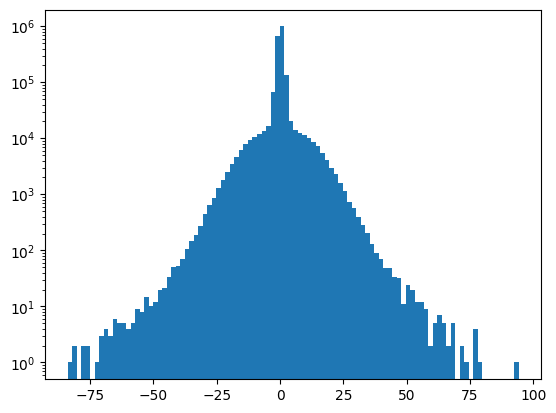

In [173]:
plt.hist(model.encoder(torch.tensor(arrs[:1000])).flatten().detach(), bins=100)
plt.yscale("log")

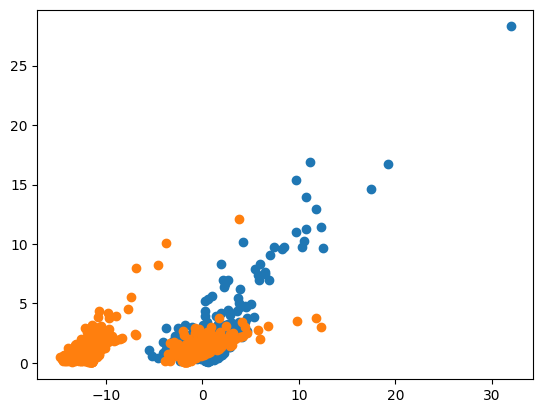

In [174]:
plt.scatter(model(torch.tensor(arrs[:1000])).detach().numpy()[:, 1], arrs[:1000][:, 1])
plt.scatter(model(torch.tensor(arrs[10000:11000])).detach().numpy()[:, 1], arrs[10000:11000][:, 1])